In [1]:
import qutip
from quantum_routines import generate_empty_initial_state, generate_mixing_Ham, generate_Ham_from_graph, generate_detuning_Ham
from qutip import mcsolve, sesolve, sigmaz, sigmap, qeye, tensor, Options, expect, sigmam
from settings import init
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator
from time import time
from data_preprocessing import load_dataset
from utils import entropy, return_energy_distribution, return_js_matrix
import numba
import pickle
from estimators import QuantumKernelEstimator
import settings
import grakel
from grakel.utils import graph_from_networkx
import matplotlib.animation as animation
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.cluster import KMeans


In [2]:
graphs, targets = load_dataset('PTC_FM', min_node=1, max_node=16)
N_sample = len(graphs)
sample = np.arange(
        len(graphs)
        ).astype(int)

# print(N_sample)

graphs_sample = graphs[sample]
targets_sample = targets[sample]

graphs_sample = [nx.convert_node_labels_to_integers(G) for G in graphs_sample]
#graphs_sample = [G.remove_edges_from(nx.selfloop_edges(G)) for G in graphs_sample]
graphs_sample = np.array(graphs_sample, dtype=object)


<class 'networkx.classes.graph.Graph'>
<class 'networkx.classes.graph.Graph'>
<class 'networkx.classes.graph.Graph'>


In [117]:
G = graphs_sample[0]
t0=time()
N_nodes = G.number_of_nodes()
H_m = generate_mixing_Ham(N_nodes)
H_d = generate_detuning_Ham(N_nodes)
H_r = generate_Ham_from_graph(G, type_h='ising')
t1=time()

def coef_rabi(t, args):
    return 1 - np.cos(np.pi*t)**2

def coef_detuning(t, args):
    return .5

state = generate_empty_initial_state(N_nodes)

opts = Options()
opts.store_states = True

result = sesolve([H_r, [H_m, coef_rabi], [H_d, coef_detuning]], state, [0, 1.], options=opts)
state = result.states[-1]
t2=time()

print((t1-t0)/(t2-t0))

0.7624744499218469


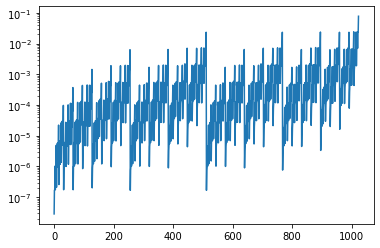

In [27]:
proba = np.abs(state.data.toarray())**2
plt.plot(proba)
plt.yscale('log')

In [3]:
mixing_ham = dict()
detuning_ham = dict()
rydberg_ham = dict()
for i, G in enumerate(graphs_sample):
    N_nodes = G.number_of_nodes()
    mixing_ham[i] = generate_mixing_Ham(N_nodes)
    detuning_ham[i] = generate_detuning_Ham(N_nodes)
    rydberg_ham[i] = generate_Ham_from_graph(G, type_h='ising')

In [4]:
def coef_rabi(t, args):
    return 1 - np.cos(np.pi*t)**2

def coef_detuning(t, args):
    return .5

def return_evolution(G, i, evol='xy', coef_rabi=(lambda t, args:1.), coef_detuning=(lambda t, args:1.)):
    assert evol in ['xy', 'ising']
    
    N_nodes = G.number_of_nodes()
    H_m = mixing_ham[i]
    H_d = detuning_ham[i]
    H_r = rydberg_ham[i]


    state = generate_empty_initial_state(N_nodes)

    opts = Options()
    opts.store_states = True

    result = sesolve([H_r, [H_m, coef_rabi], [H_d, coef_detuning]], state, [0, 3.], options=opts)
    state = result.states[-1]

    return state

def return_list_of_states(graphs_list,
    evol='xy', coef_rabi=(lambda t, args:1.), 
    coef_detuning=(lambda t, args:1.), verbose=0):
    all_states = []
    for i, G in enumerate(graphs_list):
        all_states.append(return_evolution(G, i, evol, coef_rabi, coef_detuning))
        if verbose > 0:
            if i%verbose == 0:
                print(i)
    return all_states

def observable(graph):
    N = graph.number_of_nodes()

    si = qeye(2)
    sp = sigmap()
    sm = sigmam()

    sz = sigmaz()

    sp_list = []
    sz_list = []
    sm_list = []
    sn_list = []

    for j in range(N):
        op_list = [si for _ in range(N)]

        op_list[j] = sp
        sp_list.append(tensor(op_list))

        op_list[j] = sm
        sm_list.append(tensor(op_list))

        op_list[j] = sz
        sz_list.append(tensor(op_list))

        op_list[j] = 0.5 * (sz + si)
        sn_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0
    
    for node in graph.nodes.data():
        #node_weight = graph.degree[node[0]]
        node_weight = 0
        H += node_weight * sz_list[node[0]]

    for edge in graph.edges.data():
        edge_weight = 1
        H += edge_weight * sz_list[edge[0]] * sz_list[edge[1]]

    return H

def fit_model(matrix):
    C_list = np.logspace(-3, 3, 7)

    K = np.exp(-matrix)
    param_grid = {'C': C_list}
    scoring = {'accuracy': make_scorer(accuracy_score),
                'recall': make_scorer(recall_score, average='weighted'),
                'f1_score': make_scorer(f1_score, average='weighted')
                }

    skf = RepeatedStratifiedKFold(10, 10, random_state=47)

    estimator = svm.SVC(kernel='precomputed', random_state=76)

    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=-1)
    result = grid_search.fit(K, targets_sample).cv_results_

    return -np.max(result['mean_test_accuracy'])

In [5]:
observables = dict()
for i, G in enumerate(graphs_sample):
    observables[i] = observable(G)
    
def get_observable(G, i):
    return observables[i]

In [121]:
t0=time()
states = return_list_of_states(graphs_sample, evol='ising', coef_rabi=coef_rabi, coef_detuning=coef_detuning)
energies = return_energy_distribution(graphs_sample, states, get_observable)
matrix = return_js_matrix(energies)
t1=time()

In [122]:
t1 - t0

36.957127809524536

In [123]:
fit_model(matrix)

-0.6146376811594204

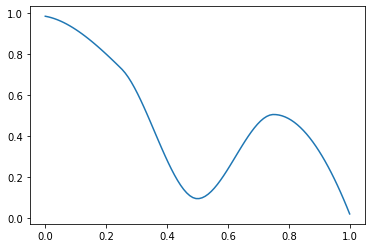

In [49]:
x0 = np.linspace(0, 1, 5)
y0 = np.random.uniform(0, 1, size=5)
func = PchipInterpolator(x0, y0)

x = np.linspace(0, 1, 100)
y = func(x)
plt.plot(x, y)

In [9]:
x0 = np.linspace(0, 3, 10)

def total_score(y_values):
    y_rabi = np.zeros(10)
    y_rabi[1:9] = y_values[0:8]
    y_detuning = y_values[8:18]
    
    t0=time()
    interpolator_rabi = PchipInterpolator(x0, y_rabi)
    interpolator_detuning = PchipInterpolator(x0, y_detuning)
    t1=time()
    
    
    def coef_rabi(t, args):
        return interpolator_rabi(t)

    def coef_detuning(t, args):
        return interpolator_detuning(t)
    try:
        states = return_list_of_states(graphs_sample, evol='ising', coef_rabi=coef_rabi, coef_detuning=coef_detuning)
        t2=time()
        energies = return_energy_distribution(graphs_sample, states, get_observable)
        t3=time()
        matrix = return_js_matrix(energies)
        t4=time()
        score = fit_model(matrix)
        t5 = time()
    except:
        score = 0
    
    return score

In [133]:
y0 = np.random.uniform(0, 1, size=8)
t0=time()
total_score(y0)
t1=time()
print(t1-t0)

68.30524110794067


In [10]:
bounds = [(0., 5.)] * 8 + [(-5., 5.)] * 10

opt_result = gp_minimize(
    total_score,
    bounds,
    acq_func='LCB',
    n_calls=60,
    n_initial_points=30,
    acq_optimizer='sampling',
    kappa=4,
    n_jobs=-1)

//anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
//anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
//anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
//anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
//anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
//anaconda3/lib/python3.7/site

In [149]:
opt_result.x_iters

[[0.2126452568799751,
  0.08561861174494347,
  0.3701960316979967,
  0.8112446058276301,
  0.3568743983683787,
  0.7961738923650953,
  0.28192976474994197,
  0.97832792342366,
  0.8081573888095199,
  -0.3022452754376689,
  0.38473146461467866,
  -0.4342659116936761,
  0.6549932297272891,
  0.0712841070972845,
  -0.4598962808823045,
  0.11889469832353972,
  -0.9543504832971417,
  -0.9981241277029296],
 [0.4211743399482797,
  0.9830364430156419,
  0.532051366639075,
  0.2805418966535164,
  0.1915545027834164,
  0.07371970690134945,
  0.9948021607979712,
  0.2083542704647861,
  0.6697568024122107,
  -0.6836159849310806,
  -0.5467049983780968,
  -0.7177578524369259,
  0.945980802273056,
  0.9153139369212322,
  0.4393713703132367,
  -0.8919544533914776,
  -0.9464857487760947,
  0.961141141568268],
 [0.2418920657475115,
  0.6530551692301276,
  0.9569804252064934,
  0.5331351217373752,
  0.29193763997402916,
  0.46480996577225653,
  0.7806936992389649,
  0.15774365363851986,
  -0.433266107819

In [150]:
np.min(opt_result.func_vals)

-0.6280615942028986

In [151]:
np.max(opt_result.func_vals)

-0.5981340579710145

In [146]:
y_max = opt_result.x_iters[np.argmin(opt_result.func_vals)]

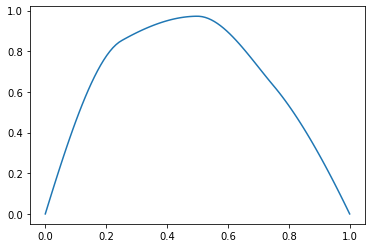

In [147]:
x0 = np.linspace(0, 1, 5)
y_rabi = np.zeros(5)
y_rabi[1:4] = y_max[0:3]
func = PchipInterpolator(x0, y_rabi)

x = np.linspace(0, 1, 100)
y = func(x)
plt.plot(x, y)

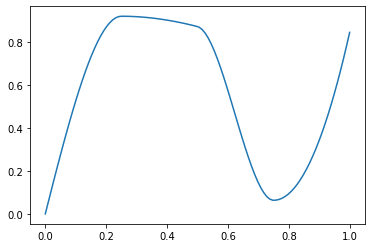

In [148]:
x0 = np.linspace(0, 1, 5)
func = PchipInterpolator(x0, y_max[3:8])

x = np.linspace(0, 1, 100)
y = func(x)
plt.plot(x, y)